In [16]:
# In this tutorial we will write from scratch a simple transformer model
# with single-head attention layer, using Tensorflow

# X - input matrix, dimension n * d_model, n is the number of tokens
# We compute Query, Key and Value matrices,
# Query = X * W_Q
# Key = X * W_K
# Value = X * W_V
# W_{Q,L,V} - learned weight matrices
# Attention(Q,K,V) = softmax(Query * Key^T / \sqrt(d_k) ) * Value
# Query * Key^T - computing pairwise similarity scores between tokens
# / \sqrt(d_k) - normalization (large vector effect)
# softmax - transform scores into probabilities
# * Value - weights values by attention scores

In [17]:
import tensorflow as tf
import math

In [18]:
class SingleHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, d_k, **kwargs):
        """
        Args:
            d_model: Dimensionality of the input embeddings.
            d_k: Dimensionality for the queries, keys, and values.
                 ---
                 The core operation in attention is the dot product 
                 between queries and keys. For this dot product to be valid, 
                 the query and key vectors must have the same dimension. 
                 ---
                 Alternatively, we would require additional transformation
                 to align dimensions.
        """
        super(SingleHeadAttention, self).__init__(**kwargs)
        self.d_model = d_model
        self.d_k = d_k

        # Linear layers for Query, Key, and Value
        # TF Dense layer computes a transformation of the form: y=XW+b
        # Which is exactly what we are aiming to do
        self.wq = tf.keras.layers.Dense(d_k)
        self.wk = tf.keras.layers.Dense(d_k)
        self.wv = tf.keras.layers.Dense(d_k)
        # Optional final dense layer to project back to d_model dimension
        # It's more important for cases with mutliple attention heads, which require 
        # concatenation of outputs.
        # We will leave it for completeness
        self.dense = tf.keras.layers.Dense(d_model)

    def call(self, x):
        """
        Args:
            x: Input tensor of shape (batch_size, seq_length, d_model)
        Returns:
            output: Tensor of shape (batch_size, seq_length, d_model)
            attention_weights: Tensor of shape (batch_size, seq_length, seq_length)
        """
        # Compute Q, K, V matrices
        Q = self.wq(x)  # (batch_size, seq_length, d_k)
        K = self.wk(x)  # (batch_size, seq_length, d_k)
        V = self.wv(x)  # (batch_size, seq_length, d_k)

        # Compute the dot products between Q and K^T
        # scores shape: (batch_size, seq_length, seq_length)
        scores = tf.matmul(Q, K, transpose_b=True)

        # Scale the scores
        scores = scores / math.sqrt(self.d_k)

        # Apply softmax to get the attention weights
        attention_weights = tf.nn.softmax(scores, axis=-1)

        # Multiply the attention weights by the V matrix to get the output
        attention_output = tf.matmul(attention_weights, V)  # (batch_size, seq_length, d_k)

        # Optionally, project the output back to d_model dimension
        output = self.dense(attention_output)  # (batch_size, seq_length, d_model)
        return output, attention_weights


In [28]:
batch_size = 2
seq_length = 3
d_model = 16
d_k = 8

# Create dummy input data
dummy_input = tf.random.uniform((batch_size, seq_length, d_model))
print("input", dummy_input)

# Initialize and call the attention layer
attention_layer = SingleHeadAttention(d_model, d_k)
output, attn_weights = attention_layer(dummy_input)

print("Output shape:", output.shape) # Expected: (batch_size, seq_length, d_model)
print("Attention weights:", attn_weights) 
print("Attention weights shape:", attn_weights.shape) # Expected: (batch_size, seq_length, seq_length)

input tf.Tensor(
[[[0.67898333 0.65998733 0.0076412  0.68809557 0.04945338 0.71485984
   0.21802402 0.4134797  0.7995225  0.97210467 0.47264004 0.10039985
   0.8632512  0.80847824 0.62963307 0.46375966]
  [0.26390696 0.31222498 0.61185145 0.41408443 0.685186   0.46431303
   0.46394253 0.24405694 0.08512807 0.0776546  0.00355649 0.815848
   0.17615402 0.2074641  0.81066537 0.9257114 ]
  [0.6281488  0.17580938 0.1155225  0.41840672 0.9343326  0.2072035
   0.8145603  0.4319359  0.1788615  0.06442642 0.18461561 0.07547843
   0.44993734 0.10015655 0.7201687  0.35097647]]

 [[0.13236713 0.55928576 0.2678516  0.07935917 0.5479156  0.85862076
   0.09885895 0.5835713  0.56326807 0.82210815 0.2779752  0.4260409
   0.16854334 0.6837851  0.585641   0.7409786 ]
  [0.37479138 0.84219646 0.7647048  0.23238194 0.12509525 0.47940254
   0.08150017 0.5011556  0.1554234  0.48021924 0.34506392 0.3762164
   0.37518096 0.06120658 0.02597237 0.7343701 ]
  [0.09509385 0.3911016  0.8239187  0.17954838 0.7451188

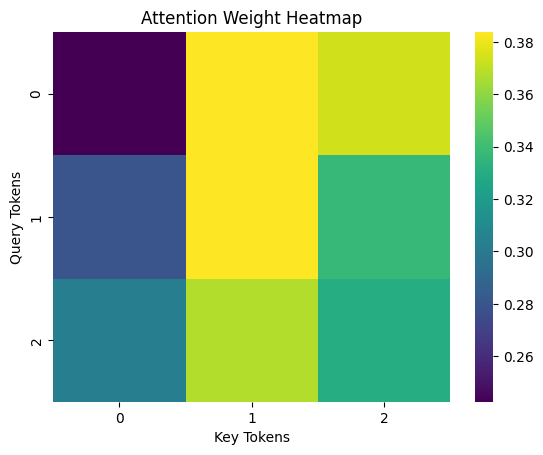

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming `attn_weights` is a numpy array of shape (seq_length, seq_length)
sns.heatmap(attn_weights[0], cmap="viridis")
plt.xlabel("Key Tokens")
plt.ylabel("Query Tokens")
plt.title("Attention Weight Heatmap")
plt.show()